# Prepare the input tensor for the Magic Wand demo
We read the acceleration and gyroscope data, measured for the gesture representing a digit, and convert them to a raster image showing the digit. This raster image is used as input tensor to the Magic Wand model

In [6]:
import matplotlib.pyplot as plt
import numpy as np

Read the acceleration and gyroscope data files for a digit

In [7]:
stroke_type = "four"
series_number = "1"

In [8]:
acceleration_data_list = []

Read the acceleration data from a file
The filename has the form: **acc_six_1.txt** for the first measurement of the gesture representing "six"

In [9]:
f = open("acc_" + stroke_type + "-" + series_number + ".txt","r")
acceleration_txt = f.read().split("\n")
f.close()

Convert the text lines into a numpy array

In [10]:
for i in range(1,len(acceleration_txt)):
    if acceleration_txt[i] == "": # skip empty lines
        continue    
    acc_xyz = acceleration_txt[i].split(',')
    acc = [float(acc_xyz[0]),float(acc_xyz[1]),float(acc_xyz[2])]
    acceleration_data_list.append(acc)
for i in range(10):
    print(acceleration_data_list[i])

[0.0077, -0.5703, 0.8888]
[0.0723, -0.5639, 0.802]
[0.078, -0.5965, 0.8487]
[0.083, -0.5954, 0.852]
[0.0864, -0.5928, 0.8579]
[0.0798, -0.5943, 0.8676]
[0.0735, -0.5932, 0.8769]
[0.0608, -0.5932, 0.8972]
[0.0491, -0.596, 0.9121]
[0.0466, -0.5925, 0.9169]


In [11]:
acceleration_data = np.array(acceleration_data_list)
print("Shape of acceleration data: ",acceleration_data.shape)

Shape of acceleration data:  (504, 3)


Revert the y and z axis
This takes into account the way the accelerometer is mounted onto the magic wand

In [12]:
# acceleration_data[:,0] = -acceleration_data[:,0]
acceleration_data[:,1] = -acceleration_data[:,1]
acceleration_data[:,2] = -acceleration_data[:,2]

In [13]:
sample_frequency = 104 # Data have been sampled at 104 Hz

In [14]:
def plot_magic_wand_data(data_array,data_name=None,title=None,start_point=None):
    data_x = data_array[:,0]
    data_y = data_array[:,1]
    data_z = data_array[:,2]
    x = np.arange(0,len(data_x)*1.0/sample_frequency,1.0/sample_frequency)
    plt.plot(x,data_x,label="x component")
    plt.plot(x,data_y,label="y_component")
    plt.plot(x,data_z,label="z component")
    plt.xlabel("Time [s]")
    if data_name:
        plt.ylabel(data_name)
    plt.title(title)
    plt.legend()

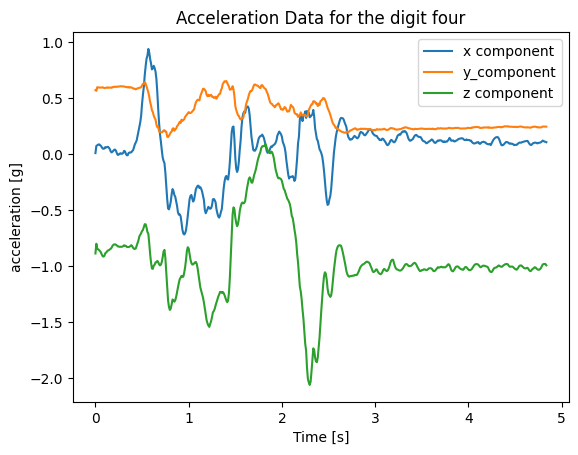

In [15]:
plot_magic_wand_data(acceleration_data,data_name="acceleration [g]",title="Acceleration Data for the digit " + stroke_type)

Plot the data array. It consists on ~ 500 acceleration vectors ax,ay,az

In [16]:
sample_frequency = 104 # Data have been sampled at 104 Hz

In [17]:
def plot_magic_wand_data(data_array,data_name=None,title=None,start_point=None):
    data_x = data_array[:,0]
    data_y = data_array[:,1]
    data_z = data_array[:,2]
    x = np.arange(0,len(data_x)*1.0/sample_frequency,1.0/sample_frequency)
    plt.plot(x,data_x,label="x component")
    plt.plot(x,data_y,label="y_component")
    plt.plot(x,data_z,label="z component")
    plt.xlabel("Time [s]")
    if data_name:
        plt.ylabel(data_name)
    plt.title(title)
    plt.legend()

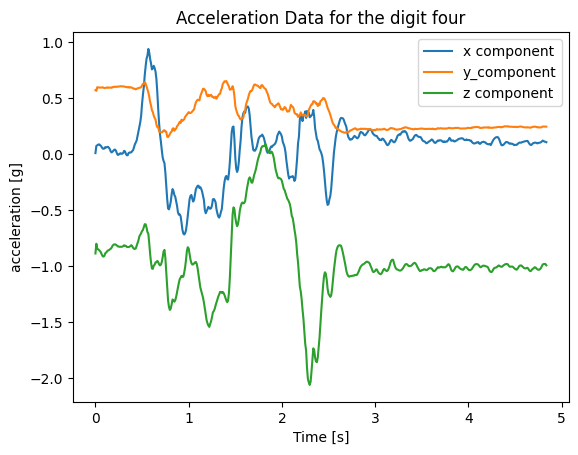

In [18]:
plot_magic_wand_data(acceleration_data,data_name="acceleration [g]",title="Acceleration Data for the digit " + stroke_type)

# Evaluate the acceleration data
Calculate and plot velocities and positions through integration

In [19]:
current_gravity  = [0.0, 0.0, 0.0]
current_gyroscope_drift = [0.0, 0.0, 0.0]
current_velocity = [0.0,0.0,0.0]
current_position = [0.0,0.0,0.0]
data_index = 0

In [20]:
def EstimateGravityDirection():
    samples_to_average = 20
    if samples_to_average >= data_index:
        samples_to_average = data_index
    #print("samples to average: {:d}".format(samples_to_average))
    start_index = data_index - samples_to_average 
    # print("Start index: {:d}".format(start_index))
    x_total = 0
    y_total = 0
    z_total = 0
    # print("Entry index: {:d}".format(start_index % data_length))
    for i in range(samples_to_average):
        index = start_index + i
        entry = acceleration_data[index]
        x_total += entry[0]
        y_total += entry[1]
        z_total += entry[2]
    gravity = [x_total/samples_to_average,y_total/samples_to_average,z_total/samples_to_average]
    return gravity

In [21]:
data_index = 1
gravity = EstimateGravityDirection()
print("Gravity: ",gravity)

Gravity:  [0.0077, 0.5703, -0.8888]


Calculate the gravity evolution

In [22]:
data_index = 1
gravity_evolution = []
for i in range(len(acceleration_data)-1):
    data_index += 1
    gravity_evolution.append(EstimateGravityDirection())
# print("Gravity evolution: ",gravity_evolution)
gravity_data = np.array(gravity_evolution)

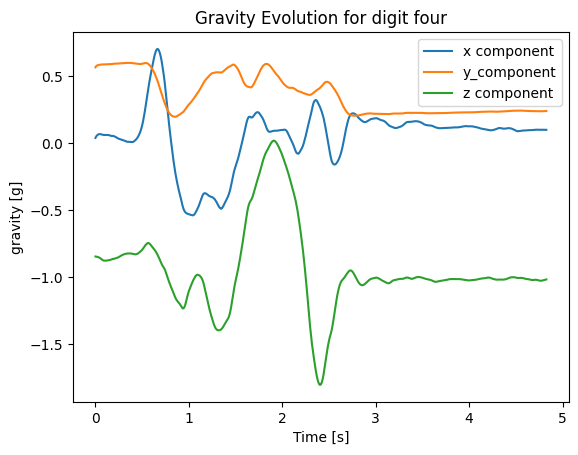

In [23]:
plot_magic_wand_data(gravity_data, data_name = "gravity [g]",title = "Gravity Evolution for digit " + stroke_type)

In [24]:
gravity = gravity_data[0]
global current_velocity,current_position
current_velocity = np.zeros(3)
current_position = np.zeros(3)

In [25]:
def UpdateVelocity(gravity):
    global current_velocity,current_position
    # print("UpdateVelocity, velocities before calc: ",velocities)
    friction_fudge = 0.98
    acc = acceleration_data[data_index]
    # print("Acceleration entry: ",acc)
    # print("Gravity: ",gravity)

    # remove the gravity from the acceleration values
    acc_minus_gravity = acc - gravity

    # print("acc minus gravity: ",ax_minus_gravity,ay_minus_gravity,az_minus_gravity)
    # update the velocity based on the normalized acceleration
    
    current_velocity += acc_minus_gravity
        
    # dampen the velocity slightly with a fudge facor to stop it exploding
    current_velocity *= friction_fudge

    # print("Current velocity: ",current_velocity)

    # update the position estimate based on the velocity
    current_position += current_velocity
    # print("UpdateVelocity, velocities after calc: ",velocities)
    return current_velocity.tolist(),current_position.tolist()

In [26]:
data_index = 0
velocities = []
positions = []
for _ in range(len(acceleration_data)-1):
    v,p = UpdateVelocity(gravity_data[data_index])
    velocities.append(v)
    positions.append(p)
    data_index += 1


Now that we have the velocity and position evolutions, let's plot it

In [27]:
velocity_data = np.array(velocities)
position_data = np.array(positions)

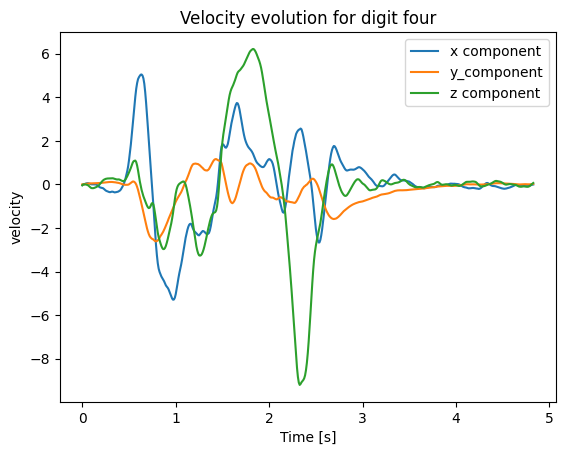

In [28]:
plot_magic_wand_data(velocity_data,data_name = "velocity", title="Velocity evolution for digit " + stroke_type)

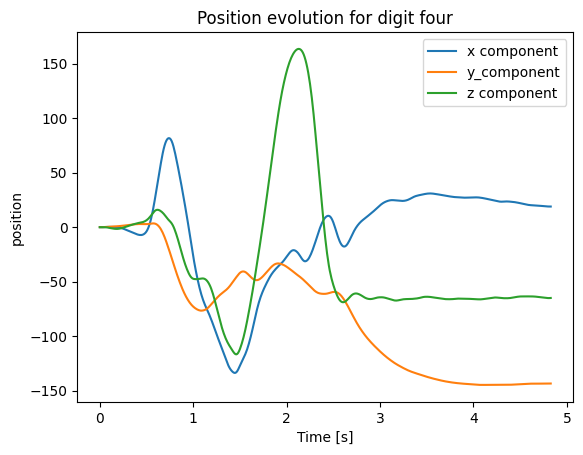

In [29]:
plot_magic_wand_data(position_data,data_name = "position", title="Position evolution for digit " + stroke_type)

In [30]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

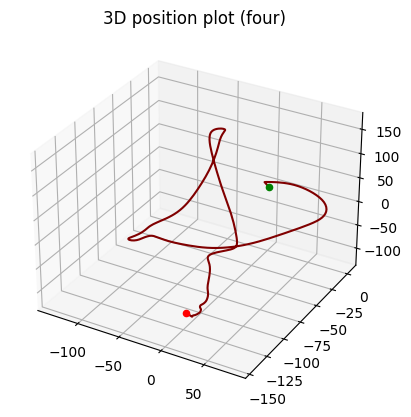

In [31]:
end = len(position_data) -1
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(position_data[:,0][0],position_data[:,1][0],position_data[:,2][0],color="green")
ax.scatter3D(position_data[:,0][end],position_data[:,1][end],position_data[:,2][end],color="red")
ax.plot3D(position_data[:,0], position_data[:,1], position_data[:,2], 'maroon')
ax.set_title('3D position plot (' + stroke_type + ')')
plt.show()

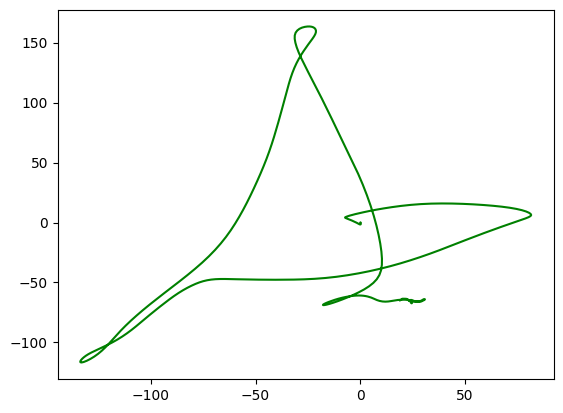

In [32]:
plt.plot(position_data[:,0],position_data[:,2],color="green")

In [33]:
print("Position data at start :",position_data[0])
print("position data at end: ",position_data[end])

Position data at start : [-0.031654  0.003136 -0.042532]
position data at end:  [  18.89857629 -143.47972046  -64.98972994]


# Evaluate the Gyroscope Data
Gyroscope data for several digits have been recorded. This notebook evaluates those data

In [182]:
gyroscope_data_list = []

In [183]:
f = open("gyro_" + stroke_type + "-" + series_number + ".txt","r")
gyroscope_txt = f.read().split("\n")
f.close()

In [184]:
for i in range(1,len(gyroscope_txt)):
    if gyroscope_txt[i] == "": # skip empty lines
        continue    
    gyro_xyz = gyroscope_txt[i].split(',')
    gyro = [float(gyro_xyz[0]),float(gyro_xyz[1]),float(gyro_xyz[2])]
    gyroscope_data_list.append(gyro)
for i in range(10):
    print(gyroscope_data_list[i])

[68.3004, -68.2394, -68.6056]
[303.5981, -8.4841, -33.8145]
[340.9528, -169.5608, 23.072]
[83.1324, -96.6216, -16.6021]
[5.9816, -5.1271, -0.8545]
[4.944, -3.9674, -0.9156]
[4.6388, -3.7843, -1.1597]
[4.3947, -4.4557, -1.2207]
[4.0284, -5.1881, -1.3428]
[3.6012, -5.1881, -1.587]


In [185]:
gyroscope_data = np.array(gyroscope_data_list)

Skip the first few samples which seem to be out of bounds

In [186]:
gyroscope_data = gyroscope_data[6:]

In [187]:
print("Shape of gyroscope data: ",gyroscope_data.shape)

Shape of gyroscope data:  (498, 3)


Revert the y and z axis
This takes into account the way the accelerometer is mounted onto the magic wand

In [188]:
# gyroscope_data[:,0] = -gyroscope_data[:,0]
gyroscope_data[:,1] = -gyroscope_data[:,1]
gyroscope_data[:,2] = -gyroscope_data[:,2]

Plot the data array. It consists on ~ 500 acceleration vectors ax,ay,az

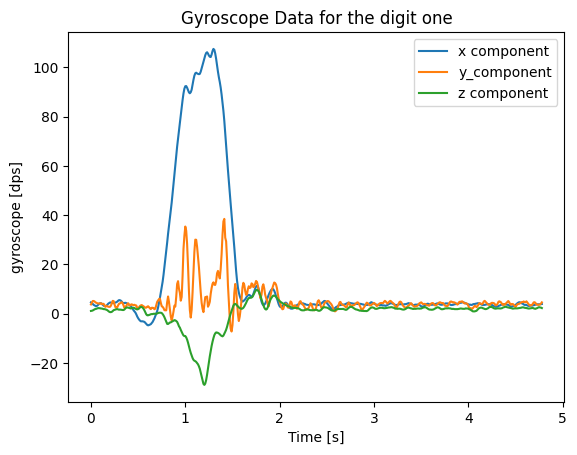

In [189]:
plot_magic_wand_data(gyroscope_data,data_name="gyroscope [dps]",title="Gyroscope Data for the digit " + stroke_type)

### Start evaluation
Estimate the gyroscope drift

In [190]:
from math import sqrt
def VectorMagnitude(vector):
    return sqrt(vector[0]*vector[0] + vector[1]*vector[1] + vector[2]*vector[2])

In [191]:
velocity_magnitude = []
for i in range(len(velocity_data)):
    velocity_magnitude.append(VectorMagnitude(velocity_data[i]))

Text(0.5, 1.0, 'Velocity magnitude')

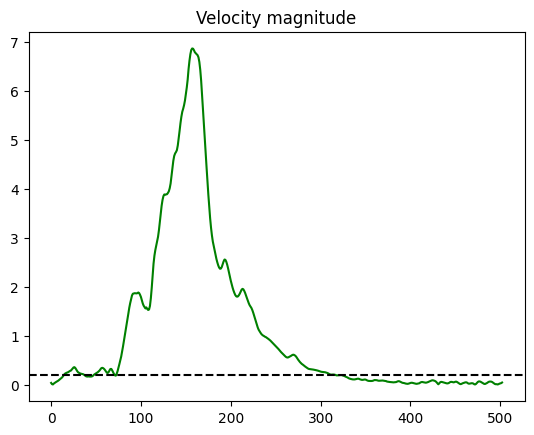

In [192]:
plt.plot(velocity_magnitude, color="green")
plt.axhline(y=0.2,color="black", linestyle="--")
plt.title("Velocity magnitude")

In [193]:
current_gyroscope_drift = np.zeros(3)

In [194]:
def EstimateGyroscopeDrift(drift):
    isMoving = VectorMagnitude(current_velocity) > 0.2
    if isMoving:
        # print("Moving at index {:d} vector magnitude: {:6.2f}".format(data_index,VectorMagnitude(current_velocity))) 
        return None
        
    samples_to_average = 20;
    if samples_to_average >= data_index:
        samples_to_average = data_index
    # print("samples to average: ",samples_to_average)
    total = np.zeros(3)
    
    for i in range(samples_to_average):
        index = data_index + i
        total += gyroscope_data[index]
    # print("total: ",total)
    drift_array = total / samples_to_average

    return drift_array.tolist()

In [195]:
drift = []
new_drift = [0.0,0.0,0.0]
data_index = 1
for i in range(1,len(gyroscope_data) -20):
    current_velocity = velocity_data[data_index]
    new_drift = EstimateGyroscopeDrift(new_drift) 
    if new_drift:
        drift.append(new_drift)
    data_index += 1

In [196]:
gyroscope_drift_data = np.array(drift) 

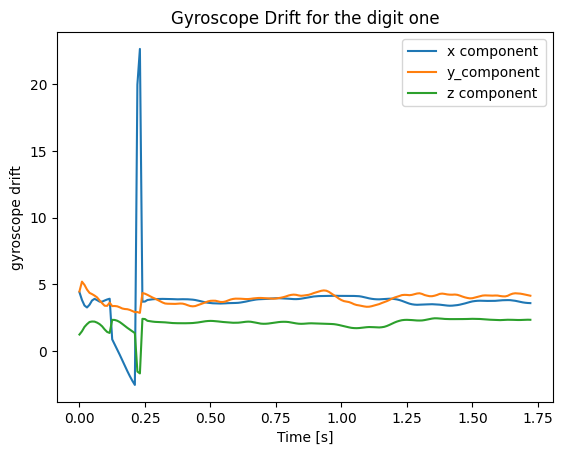

In [197]:
plot_magic_wand_data(gyroscope_drift_data,data_name="gyroscope drift",title="Gyroscope Drift for the digit " + stroke_type)

In [198]:
total = np.zeros(3)
for i in range(len(gyroscope_drift_data)):
    total += gyroscope_drift_data[i]
average_gyroscope_drift = total / len(gyroscope_drift_data)

In [199]:
print("Average gyroscope drift: ",average_gyroscope_drift)

Average gyroscope drift:  [3.71485093 3.90469245 2.06928966]


In [200]:
def UpdateOrientation():
    # print(start_index)
    recip_sample_rate = 1.0 / sample_frequency
    d = gyroscope_data[data_index]  

    # Try to remove sensor errors from the raw gyroscope_data
    d_minus_drift = d - average_gyroscope_drift

    # Convert from degrees-per-second to appropriate units for this time interval
    d_normalized = d_minus_drift * recip_sample_rate

    # Update orientation based on the gyroscope data
    previous_index = data_index -1 
    # print("previous index: {:d}".format(previous_index))
    previous_orientation = orientations[previous_index]
    current_orientation = previous_orientation + d_normalized
    
    return current_orientation

In [201]:
orientations = [[0.0,0.0,0.0]]
data_index = 1
for i in range(1,len(gyroscope_data-1)):
    orientations.append(UpdateOrientation())
    data_index += 1
orientation_data = np.array(orientations)

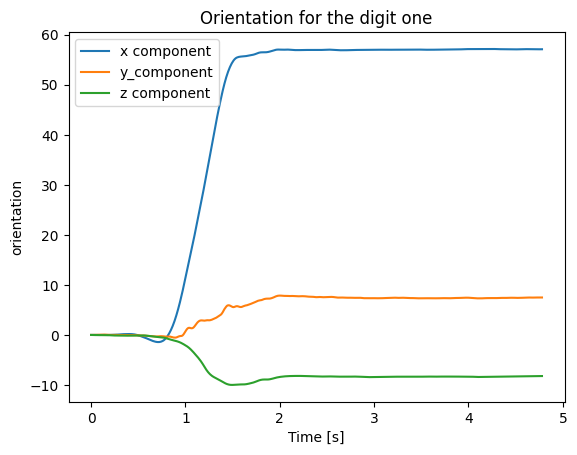

In [202]:
plot_magic_wand_data(orientation_data,data_name="orientation",title="Orientation for the digit " + stroke_type)

Compare the orientation with the position plot

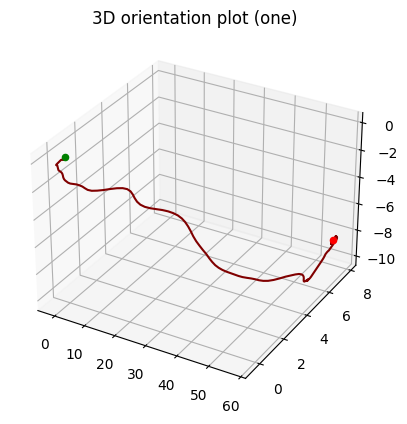

In [203]:
end = len(orientation_data) -1
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(orientation_data[:,0][0],orientation_data[:,1][0],orientation_data[:,2][0],color="green")
ax.scatter3D(orientation_data[:,0][end],orientation_data[:,1][end],orientation_data[:,2][end],color="red")
ax.plot3D(orientation_data[:,0], orientation_data[:,1], orientation_data[:,2], 'maroon')
ax.set_title('3D orientation plot (' + stroke_type + ')')
plt.show()

In [204]:
def isMoving():
    moving_threshold = 10.0
    
    if data_index - 1 < moving_sample_count:
        # print("data index: {:d}, samples_before: {:d}".format(data_index,samples_before))
        return False
        
    total = 0.0
    start_index = data_index - moving_sample_count + 1
    # print("start_index: {:d}".format(start_index))
    for i in range(moving_sample_count):
        index = start_index + i
        current_orientation = orientation_data[index]
        previous_index = index - 1
        previous_orientation = orientation_data[previous_index]
        d = current_orientation - previous_orientation
        mag_squared = (d[0] * d[0]) + (d[1] * d[1]) + (d[2] * d[2])
        # print("total: {:6.4f}".format(total))
        total += mag_squared
    # print("mag squared: {:6.4f}".format(total))
    is_moving = total > moving_threshold
    return is_moving    

In [205]:
data_index = 1
moving_sample_count = 50
moving = []
last = False
for i in range(1,len(orientation_data)):
    if last != isMoving():
        last = not last
        if last:
            print("Moving from index {:d}".format(data_index))
        else:
            print("Not moving from index {:d}".format(data_index))
    if isMoving():
        moving.append(5)
    else:
        moving.append(0)
    data_index += 1

Moving from index 107
Not moving from index 188


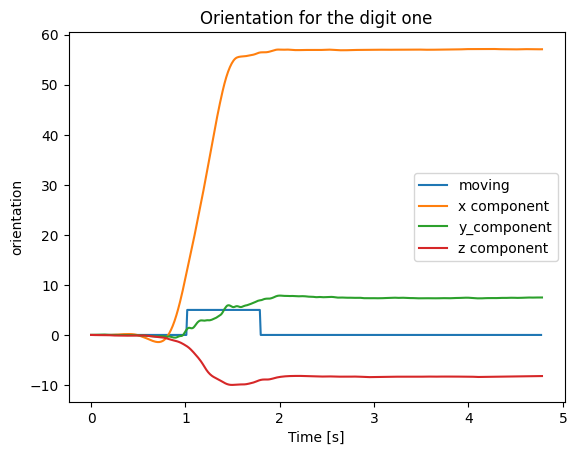

In [206]:
x = np.arange(0,len(moving)*1.0/sample_frequency,1.0/sample_frequency)
plt.plot(x,moving,label="moving")
plot_magic_wand_data(orientation_data,data_name="orientation",title="Orientation for the digit " + stroke_type)

In [207]:
eWaiting = 0
eDrawing = 1
eDone = 2
stroke_state_txt=["eWaiting","eDrawing","eDone"]
stroke_length = 0
stroke_state = eWaiting

In [208]:
def FindStrokeIndices():
    global stroke_state,data_index,stroke_length
    minimum_stroke_length = moving_sample_count + 10
    data_index = 1
    start_stroke = 0
    stop_stroke = 0
    for i in range(1,len(orientation_data)):
        old_state = stroke_state
        # print("data_index: {:d}, current state: {:s}".format(data_index,stroke_state_txt[old_state]))
        if (old_state == eWaiting) or (old_state == eDone):
            if isMoving():
                stroke_length = moving_sample_count
                print("Switched to drawing state at index {:d}".format(data_index))
                stroke_state = eDrawing
                start_stroke = data_index        
        elif old_state == eDrawing:
            if not isMoving():
                if stroke_length > minimum_stroke_length:
                    print("Switched to Done state")
                    stroke_state = eDone
                    stop_stroke = data_index
                    # return start_stroke,stop_stroke
                else:
                    stroke_length = 0
                    print("Switched to waiting state")
            else:
                stroke_length += 1
        data_index += 1
    return start_stroke,stop_stroke

In [209]:
start_stroke, stop_stroke = FindStrokeIndices()
print("Starting stroke at index {:d} stopping at {:d}".format(start_stroke, stop_stroke))

Switched to drawing state at index 107
Switched to Done state
Starting stroke at index 107 stopping at 188


In [125]:
def UpdateStroke():
    global stroke_state,stroke_length,start_drawing,stroke_points
    minimum_stroke_length = moving_sample_count + 10
    minimum_stroke_size = 0.2

    done_just_triggered = False

    current_head = data_index
    is_moving = isMoving()
    # if is_moving:
    #    print("moving at index: {:d}, stroke_state: {:d}".format(data_index,stroke_state))
    old_state = stroke_state
    if old_state == eWaiting or old_state == eDone:
        if is_moving:
            stroke_length = moving_sample_count
            print("Switched to drawing state at index {:d}".format(data_index))
            stroke_state = eDrawing
            start_drawing = data_index
    elif old_state == eDrawing:
        if not is_moving:
            if stroke_length > minimum_stroke_length:
                print("Switched to Done state")
                stroke_state = eDone
            else:
                stroke_length = 0
                print("Switched to waiting state")
                stroke_length = eWaiting
                
    is_waiting = (stroke_state == eWaiting)

    stroke_length += 1

    # only recalculate the full stroke if it is needed
    draw_last_point = (stroke_state == eDrawing)
    done_just_triggered = ((old_state != eDone) and (stroke_state == eDone)) 
    if not done_just_triggered or draw_last_point:
        return None
    stroke_length -= start_drawing
    if stroke_length >stroke_max_length:
        stroke_length = stroke_max_length

    print("just triggered")
    start_index = start_drawing
    total = np.zeros(3)
    print("Start index: {:d}, stroke_length: {:d}".format(start_index,stroke_length))
    for j in range(stroke_length):
        index = start_index + j
        total += orientation_data[index]

    mean = total / stroke_length
    print("mean: ",mean)
    stroke_range = 90.0
    gx = current_gravity[0]
    gz = current_gravity[2]
        
    gmag = sqrt((gx * gx) + (gz * gz))
    if gmag < 0.0001:
        gmag = 0.0001
            
    ngx = gx / gmag
    ngz = gz / gmag
  
    xaxisz = -ngz
    xaxisy = -ngx

    yaxisz = -ngx
    yaxisy = ngz      

    print("xaxisz: {:8.4f} xaxis_y: {:8.4f} yaxisz: {:8.4f}, yaxisy: {:8.4f}".format(
        xaxisz,xaxisy,yaxisz,yaxisy))
    # stroke_transmit_length = stroke_length // stroke_transmit_stride
    stroke_transmit_length = stroke_length
    stroke_point = np.zeros(2)  
    print("start_index: {:d}".format(start_index))

    for j in range(stroke_transmit_length):
        orientation_index = start_index + j * stroke_transmit_stride 
        orientation_entry = orientation_data[orientation_index]  
        print("orientation index ",orientation_index, " and entry: ",orientation_data[orientation_index])
        orientation = orientation_entry
        n = (orientation - mean) / stroke_range
        
        x_axis = xaxisz * n[0] + xaxisy * n[1]
        y_axis = yaxisz * n[2] + yaxisy * n[1]   
        print("x_axis: {:8.4f}, y_axis: {:8.4f}".format(x_axis,y_axis))
        # stroke_index = j * 2;
        # stroke_entry = stroke_points[stroke_index]
       
        unchecked_x = int(x_axis*128.0)
    
        if (unchecked_x > 127):
            stored_x = 127
        elif unchecked_x < -128:
            stored_x = -128
        else:
            stored_x = unchecked_x
        stroke_point[0] = stored_x;
      
        unchecked_y = int(y_axis * 128.0)
        if unchecked_y > 127:
            stored_y = 127
        elif unchecked_y < -128:
            stored_y = -128
        else:
            stored_y = unchecked_y
        stroke_point[1] = stored_y
        print("Stroke point: {:d},{:d}".format(stored_x,stored_y))
        stroke_points.append(stroke_point)
        
        is_first = (j == 0)
        if is_first or (x_axis < x_min):
            x_min = x_axis
        if is_first or (y_axis < y_min):
            y_min = y_axis
      
        if is_first or (x_axis > x_max):
            x_max = x_axis;
        if is_first or (y_axis > y_max):
            y_max = y_axis
        return 

In [96]:
eWaiting = 0
eDrawing = 1
eDone = 2

In [97]:
global stroke_state,start_drawing
data_index = 1
start_drawing = 0
stroke_transmit_stride = 2
stroke_transmit_max_length = 160
stroke_max_length = stroke_transmit_max_length * stroke_transmit_stride
stroke_state = eWaiting
stroke_length = 0
stroke_points = []
print("Size of orientation data: {:d}".format(len(orientation_data)))
print("Moving sample_count: {:d}".format(moving_sample_count))
for _ in range(1,len(orientation_data)):
    current_gravity = gravity_data[data_index]
    UpdateStroke()
    data_index += 1

Size of orientation data: 498
Moving sample_count: 50
Switched to drawing state at index 101
Switched to Done state
just triggered
Start index: 101, stroke_length: 125
mean:  [ 20.21834181 -22.55985723  -7.8164211 ]
xaxisz:   0.7826 xaxis_y:  -0.6225 yaxisz:  -0.6225, yaxisy:  -0.7826
start_index: 101
orientation index  101  and entry:  [ -0.3729438  -15.16072438   6.45985491]
x_axis:  -0.2302, y_axis:  -0.1631
Stroke point: -29,-20


In [98]:
print("Stroke length: {:d}".format(stroke_length))

Stroke length: 346


In [99]:
print("No of stroke points: {:d}".format(len(stroke_points)))
print(stroke_points)

No of stroke points: 1
[array([-29., -20.])]
